# Using Simplified Cubes and Tensors Modules

This notebook demonstrates how to use the simplified `cubes.py` and `tensors.py` modules for processing rainfall data.

## 1. Setup and Imports

In [3]:
import sys
sys.path.insert(0, '../src')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from cubes import load_rainfall_cube, cube_to_array, temporal_mean
from tensors import (create_rainfall_tensor, normalize_rainfall_tensor, 
                    identify_high_rainfall, compute_tensor_statistics,
                    aggregate_tensor_time, slice_tensor)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Load Rainfall Datacube

In [4]:
# Load the rainfall datacube
cube = load_rainfall_cube('../data/processed/rainfall_datacube_aoi.nc')

print("Datacube Information:")
print(f"  Shape: {cube.get_shape()}")
print(f"  Extent: {cube.get_extent()}")

Datacube Information:
  Shape: {'time': 84, 'latitude': 15, 'longitude': 16}
  Extent: {'longitude': (32.524993896484375, 33.274993896484375), 'latitude': (15.625, 16.324996948242188)}


d:\Master\Q2\sci Programming for Geospatial\Project 2\flood-exposure-geospatial-pipeline\notebooks\../src\cubes.py:71: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  return {dim: size for dim, size in self.data.dims.items()}
<frozen _collections_abc>:861: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


## 3. Convert to NumPy Array and Create Tensor

In [5]:
# Convert datacube to NumPy array
rainfall_array = cube_to_array(cube, 'precip')

# Create tensor
rainfall_tensor = create_rainfall_tensor(rainfall_array)

# Get statistics
stats = compute_tensor_statistics(rainfall_tensor)

print("Tensor Statistics:")
for key, value in stats.items():
    print(f"  {key}: {value}")

Tensor Statistics:
  mean: 14.296713829040527
  std: 23.062477111816406
  min: 0.0
  max: 120.36732482910156
  shape: (84, 15, 16)
  size: 20160
  dtype: float32


## 4. Normalize Rainfall Data

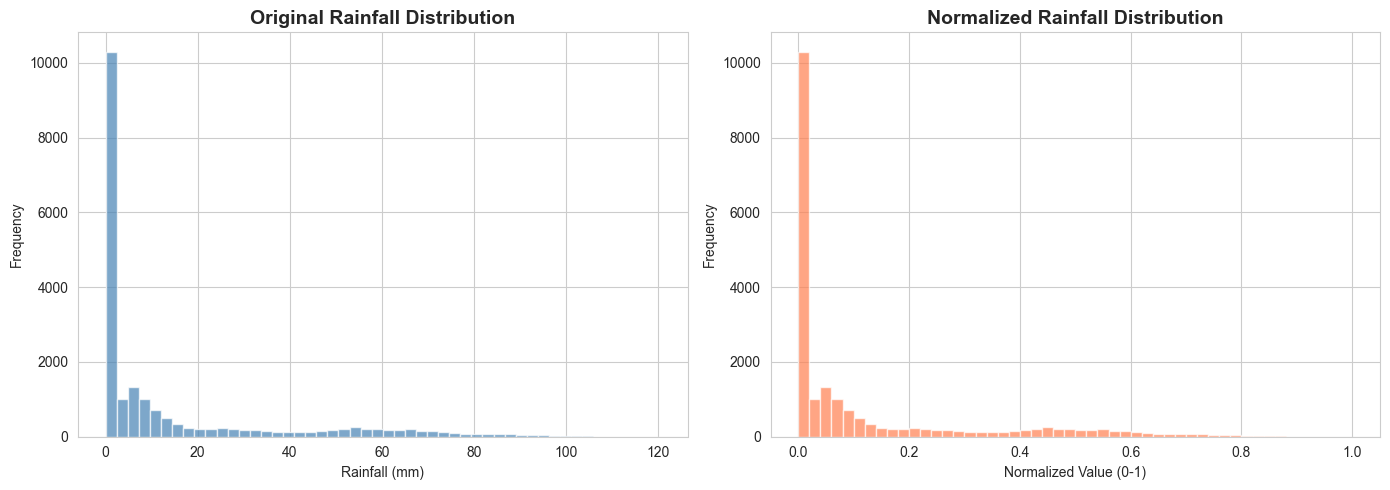

In [6]:
# Normalize using min-max method
normalized_tensor = normalize_rainfall_tensor(rainfall_tensor)

# Compare original vs normalized
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original data distribution
axes[0].hist(rainfall_tensor.flatten(), bins=50, color='steelblue', alpha=0.7)
axes[0].set_title('Original Rainfall Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Rainfall (mm)')
axes[0].set_ylabel('Frequency')

# Normalized data distribution
axes[1].hist(normalized_tensor.flatten(), bins=50, color='coral', alpha=0.7)
axes[1].set_title('Normalized Rainfall Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Normalized Value (0-1)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 5. Identify High Rainfall Events

High Rainfall Events (>50mm):
  Total events: 2512
  Percentage: 12.46%


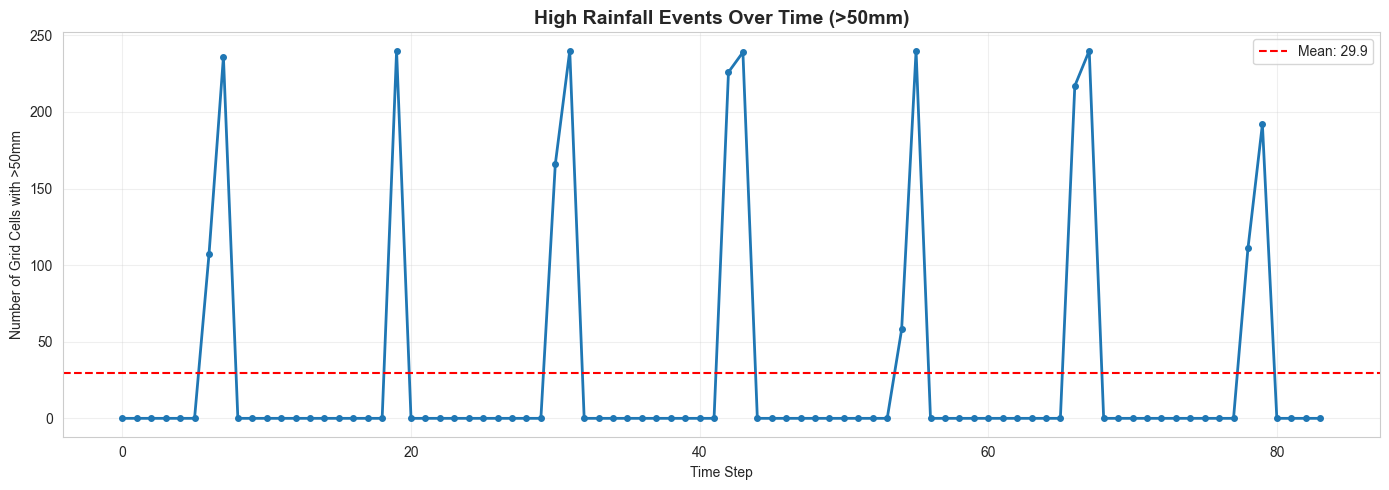

In [7]:
# Apply threshold to identify high rainfall (>50mm)
high_rainfall_mask = identify_high_rainfall(rainfall_tensor, threshold=50.0)

# Calculate percentage
percent_high = (high_rainfall_mask.sum() / high_rainfall_mask.size) * 100

print(f"High Rainfall Events (>50mm):")
print(f"  Total events: {high_rainfall_mask.sum()}")
print(f"  Percentage: {percent_high:.2f}%")

# Count high rainfall events over time
high_rain_per_timestep = high_rainfall_mask.sum(axis=(1, 2))

plt.figure(figsize=(14, 5))
plt.plot(high_rain_per_timestep, marker='o', linestyle='-', linewidth=2, markersize=4)
plt.axhline(y=high_rain_per_timestep.mean(), color='red', linestyle='--', 
            label=f'Mean: {high_rain_per_timestep.mean():.1f}')
plt.title('High Rainfall Events Over Time (>50mm)', fontsize=14, fontweight='bold')
plt.xlabel('Time Step')
plt.ylabel('Number of Grid Cells with >50mm')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Temporal Aggregations

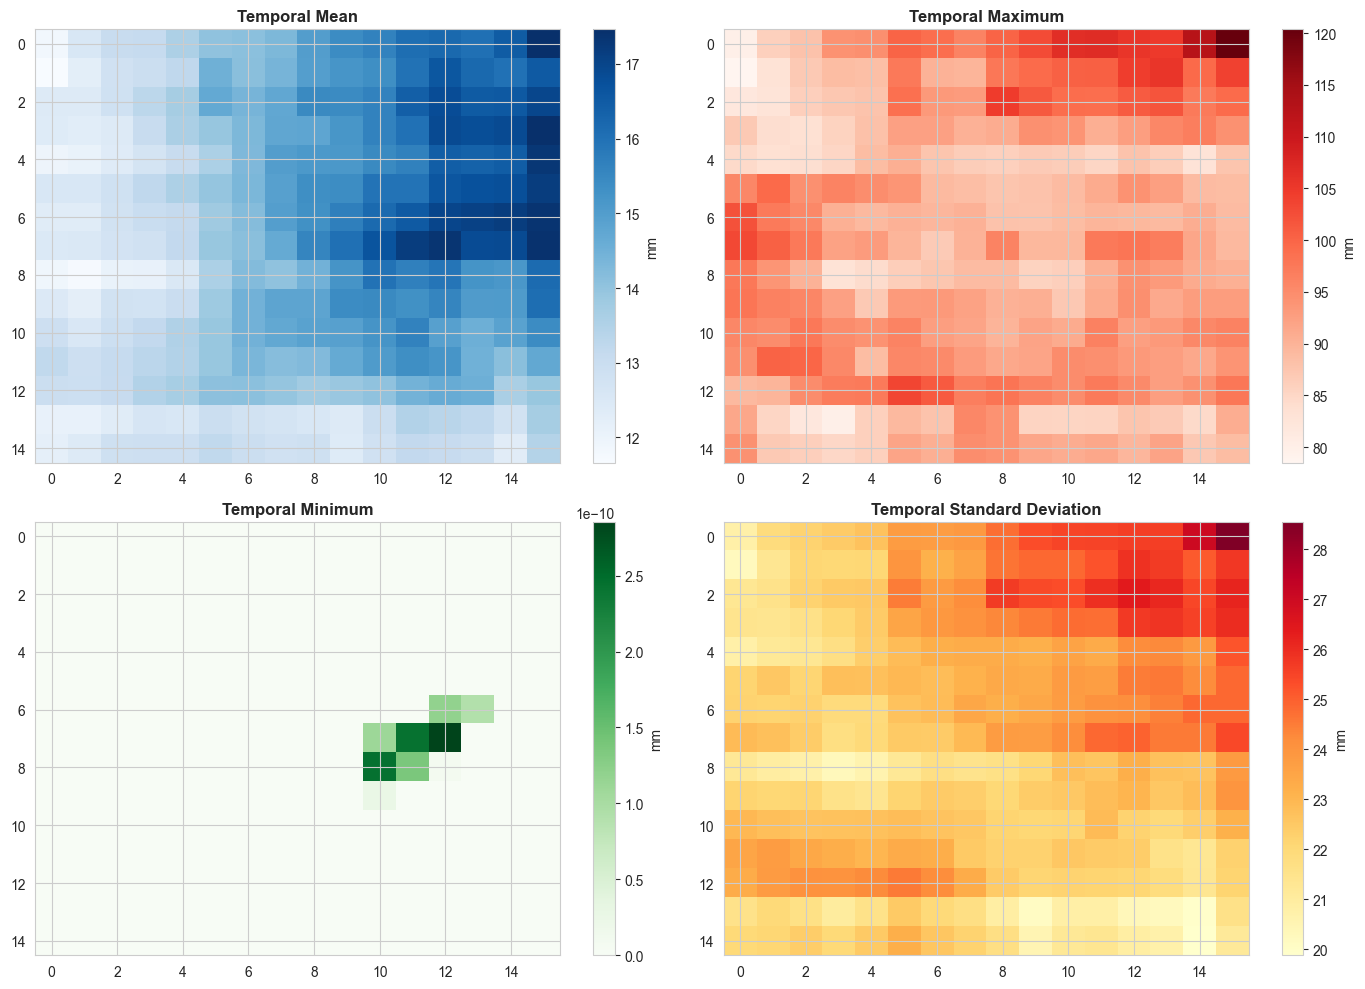

Temporal Aggregation Statistics:
  Mean rainfall (spatial avg): 14.30 mm
  Max rainfall (spatial avg): 92.41 mm
  Min rainfall (spatial avg): 0.00 mm
  Std rainfall (spatial avg): 22.96 mm


In [8]:
# Compute various temporal aggregations
mean_rainfall = aggregate_tensor_time(rainfall_tensor, method='mean')
max_rainfall = aggregate_tensor_time(rainfall_tensor, method='max')
min_rainfall = aggregate_tensor_time(rainfall_tensor, method='min')
std_rainfall = aggregate_tensor_time(rainfall_tensor, method='std')

# Visualize temporal statistics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Mean
im1 = axes[0, 0].imshow(mean_rainfall, cmap='Blues', aspect='auto')
axes[0, 0].set_title('Temporal Mean', fontsize=12, fontweight='bold')
plt.colorbar(im1, ax=axes[0, 0], label='mm')

# Max
im2 = axes[0, 1].imshow(max_rainfall, cmap='Reds', aspect='auto')
axes[0, 1].set_title('Temporal Maximum', fontsize=12, fontweight='bold')
plt.colorbar(im2, ax=axes[0, 1], label='mm')

# Min
im3 = axes[1, 0].imshow(min_rainfall, cmap='Greens', aspect='auto')
axes[1, 0].set_title('Temporal Minimum', fontsize=12, fontweight='bold')
plt.colorbar(im3, ax=axes[1, 0], label='mm')

# Std
im4 = axes[1, 1].imshow(std_rainfall, cmap='YlOrRd', aspect='auto')
axes[1, 1].set_title('Temporal Standard Deviation', fontsize=12, fontweight='bold')
plt.colorbar(im4, ax=axes[1, 1], label='mm')

plt.tight_layout()
plt.show()

print("Temporal Aggregation Statistics:")
print(f"  Mean rainfall (spatial avg): {mean_rainfall.mean():.2f} mm")
print(f"  Max rainfall (spatial avg): {max_rainfall.mean():.2f} mm")
print(f"  Min rainfall (spatial avg): {min_rainfall.mean():.2f} mm")
print(f"  Std rainfall (spatial avg): {std_rainfall.mean():.2f} mm")

## 7. Time Slice Analysis

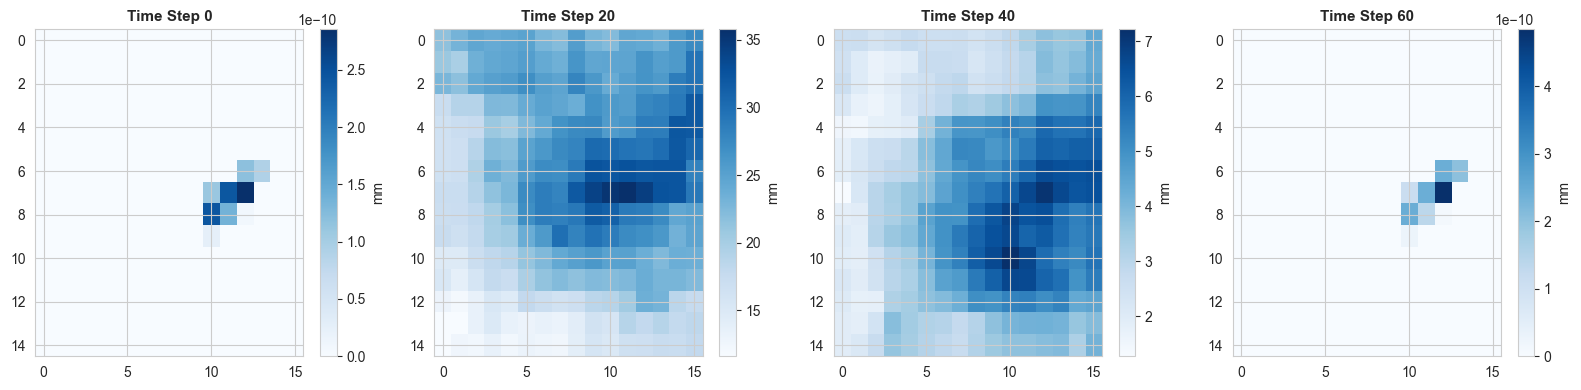

In [9]:
# Extract specific time slices
slice_indices = [0, 20, 40, 60]

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for idx, time_idx in enumerate(slice_indices):
    time_slice = slice_tensor(rainfall_tensor, time_index=time_idx)
    
    im = axes[idx].imshow(time_slice, cmap='Blues', aspect='auto')
    axes[idx].set_title(f'Time Step {time_idx}', fontsize=11, fontweight='bold')
    plt.colorbar(im, ax=axes[idx], label='mm')

plt.tight_layout()
plt.show()

## 8. Time Period Selection

Time Period Statistics:
  2023-2024: shape=(24, 15, 16), mean=14.90 mm
  2020-2022: shape=(24, 15, 16), mean=15.03 mm


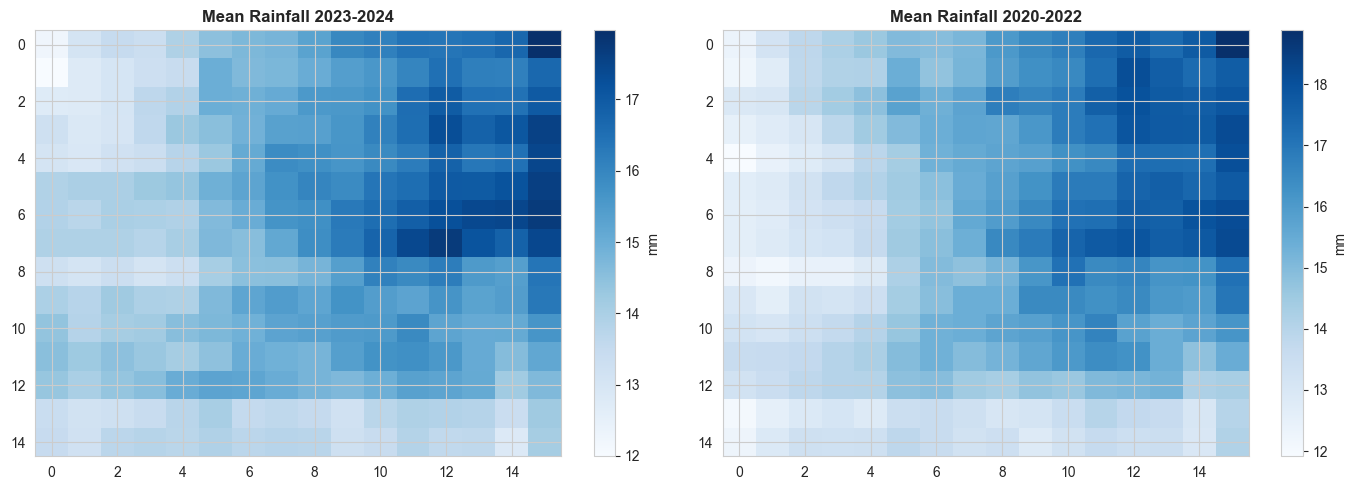

In [10]:
# Select data for specific years
period_2023_2024 = cube.select_time_period('precip', 2023, 2024)
period_2020_2022 = cube.select_time_period('precip', 2020, 2022)

print("Time Period Statistics:")
print(f"  2023-2024: shape={period_2023_2024.shape}, mean={period_2023_2024.mean():.2f} mm")
print(f"  2020-2022: shape={period_2020_2022.shape}, mean={period_2020_2022.mean():.2f} mm")

# Compare periods
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

mean_2023_2024 = period_2023_2024.mean(axis=0)
mean_2020_2022 = period_2020_2022.mean(axis=0)

im1 = axes[0].imshow(mean_2023_2024, cmap='Blues', aspect='auto')
axes[0].set_title('Mean Rainfall 2023-2024', fontsize=12, fontweight='bold')
plt.colorbar(im1, ax=axes[0], label='mm')

im2 = axes[1].imshow(mean_2020_2022, cmap='Blues', aspect='auto')
axes[1].set_title('Mean Rainfall 2020-2022', fontsize=12, fontweight='bold')
plt.colorbar(im2, ax=axes[1], label='mm')

plt.tight_layout()
plt.show()

## 9. Summary Statistics

In [ ]:
# Compute comprehensive statistics
cube_stats = cube.compute_statistics('precip')
tensor_stats = compute_tensor_statistics(rainfall_tensor)

print("=" * 60)
print("RAINFALL DATACUBE ANALYSIS SUMMARY")
print("=" * 60)

print("\nDatacube Statistics:")
for key, value in cube_stats.items():
    if isinstance(value, float):
        print(f"  {key.capitalize()}: {value:.2f} mm")
    else:
        print(f"  {key.capitalize()}: {value}")

print("\nTensor Statistics:")
for key, value in tensor_stats.items():
    if isinstance(value, float):
        print(f"  {key.capitalize()}: {value:.2f}")
    else:
        print(f"  {key.capitalize()}: {value}")

print("\n" + "=" * 60)

## Conclusion

This notebook demonstrated:
- ✅ Loading datacubes from netCDF
- ✅ Converting to NumPy arrays
- ✅ Creating and manipulating tensors
- ✅ Normalizing data
- ✅ Applying thresholds
- ✅ Temporal aggregations
- ✅ Time period selection
- ✅ Statistical analysis

The simplified modules provide all essential functionality for rainfall data processing while remaining easy to use and understand.